In [1]:
import numpy as np
import pandas as pd

import seaborn as sea

from matplotlib import pyplot as plt
from matplotlib import image as mpimg

import cv2

import random
import math
from os.path import exists

In [2]:
MIN_X_SHIFT = 15
MIN_Y_SHIFT = 10
DEFAULT_X_SHIFT = 15
DEFAULT_Y_SHIFT = 10 #23

DEFAULT_TOP_CROP = 0.18
DEFAULT_BOTTOM_CROP = 25

RESIZE_X = 1 #0.5
RESIZE_Y = 1 #0.5

BRIGHTNESS_MAX_RANGE = 0.2

DEFAULT_SCALE = 1

LEFT_FLIP_BIAS = True
FLIP_PROBABILITY = 0.7

TRAINING_FOLDER = 'Data\Training Data (1)\\' # Change this only
TRAINING_IMAGES_FOLDER = TRAINING_FOLDER + 'IMG\\'
AUG_IMAGE_FOLDER_PATH = TRAINING_FOLDER +  'Augmented_Data_2.8.1\\'
TRAINING_DATASET = TRAINING_FOLDER + 'driving_log.csv'
AUGMENTED_DATASET = TRAINING_FOLDER + 'augmented_df_2.8.1.csv'

IMAGE_FOLDER_PATH = AUG_IMAGE_FOLDER_PATH

AUGMENTATION_FACTOR = 3

---

# Shortcut

In [3]:
column_names = ['Center Camera', 'Left Camera', 'Right Camera', 'Steering Angle', 'Positve Throttle', 'Negative Throttle', 'Speed']
df = pd.read_csv(TRAINING_DATASET, header=0, names=column_names)

# df = df[df['Speed'] >= 30]
df = df[['Left Camera', 'Center Camera', 'Right Camera', 'Steering Angle']]

df_left_cam = df[['Left Camera', 'Steering Angle']]
df_center_cam = df[['Center Camera', 'Steering Angle']]
df_right_cam = df[['Right Camera', 'Steering Angle']]

df_left_cam.loc[:, 'Steering Angle'] = df_left_cam.loc[:, 'Steering Angle'] + 0.25
df_right_cam.loc[:, 'Steering Angle'] = df_right_cam.loc[:, 'Steering Angle'] - 0.25

C:\Users\kayeg\AppData\Local\Temp\ipykernel_34772\1795476378.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_left_cam.loc[:, 'Steering Angle'] = df_left_cam.loc[:, 'Steering Angle'] + 0.25
C:\Users\kayeg\AppData\Local\Temp\ipykernel_34772\1795476378.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_right_cam.loc[:, 'Steering Angle'] = df_right_cam.loc[:, 'Steering Angle'] - 0.25


In [42]:
camera = [''] * df.shape[0]
angle = [''] * df.shape[0]


df_arry = [df_left_cam, df_center_cam, df_right_cam]
for row in range(df.shape[0]):
    rand_col = np.random.randint(0, 3)
    camera[row] = df_arry[rand_col].iloc[row, 0]
    angle[row] = df_arry[rand_col].iloc[row, 1]
    
df_singleCamera = pd.DataFrame(data=zip(camera, angle) ,columns=['Camera','Steering Angle'])
df_singleCamera

,Camera,Steering Angle
0,C:\Users\kayeg\Documents\Main Folders\[2] Ain ...,0.00
1,C:\Users\kayeg\Documents\Main Folders\[2] Ain ...,-0.25
2,C:\Users\kayeg\Documents\Main Folders\[2] Ain ...,0.25
3,C:\Users\kayeg\Documents\Main Folders\[2] Ain ...,0.00
4,C:\Users\kayeg\Documents\Main Folders\[2] Ain ...,-0.25
...,...,...
5712,C:\Users\kayeg\Documents\Main Folders\[2] Ain ...,0.00
5713,C:\Users\kayeg\Documents\Main Folders\[2] Ain ...,0.25
5714,C:\Users\kayeg\Documents\Main Folders\[2] Ain ...,0.25
5715,C:\Users\kayeg\Documents\Main Folders\[2] Ain ...,-0.25


<AxesSubplot:xlabel='Steering Angle', ylabel='Count'>

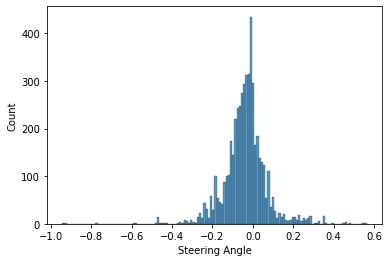

In [4]:
sea.histplot(df['Steering Angle'])

<AxesSubplot:xlabel='Steering Angle', ylabel='Count'>

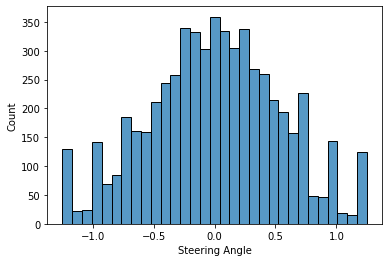

In [44]:
sea.histplot(df_singleCamera['Steering Angle'])

In [45]:
# Check if a path does not exist
for row in range(df_singleCamera.shape[0]):
    if not(os.path.exists(df_singleCamera.iloc[row]['Camera'])):
        print(row, df_singleCamera.iloc[row]['Camera'])

---

# Image Augmentation

## Auxilary Functions

In [46]:
def is_numeric(value):
    return (isinstance(value, int) or isinstance(value, float))

def is_none(value):
    return (value is None)

def is_int(value):
    return isinstance(value, int)

def is_float(value):
    return isinstance(value, float)

def is_between(value, min, max, equality_min=False, equality_max=False):    
    return (value > min and value < max) or (equality_min and value == min) or (equality_max and value == max)
    

In [47]:
def extract_from_image_path(image_path):
    folder = extract_image_folder(image_path)
    name = extract_image_name(image_path)
    camera = extract_camera_type(name)
    return folder, name, camera

def extract_image_folder(image_path):
    return '\\'.join(image_path.split('\\')[:-1])

    return folder, name, camera

def extract_image_name(image_path):
    image_path = image_path.split('\\')
    return list(filter(lambda x: '.jpg' in x, image_path))[0]
    
def extract_camera_type(image_name):
    return image_name[0:image_name.index('_')]

In [48]:
def fetch_image(image_name, image_folder):
        image_path = image_folder + '\\' + image_name
        if not(os.path.exists(image_path)):
                print(f"[fetch_image] Image Not Found, image path was '{image_path}'")
                return None

        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image

In [49]:
def save_image(image, image_name, image_folder, overwrite=False):
    if(image is None):
        print("[save_image] Image is None!!")
        return None

    if not(os.path.exists(image_folder)):
        print("[save_image] Target folder does not exist")
        return None

    if not(overwrite) and (os.path.exists(image_folder+image_name)):
        print("[save_image] Image already exists")
        return None

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # print(image_folder + image_name)
    cv2.imwrite(image_folder + image_name, image)
    return 1

In [50]:
def display_image(image, window_name = '', scale=DEFAULT_SCALE):
    if(image is None):
        print("[display_image] Image is none!!")
        return None

    image_resize = cv2.resize(image, (image.shape[1]*scale, image.shape[0]*scale))
 
    if(not(window_name)):
        window_name = f'({image.shape[0]}) X ({image.shape[1]})'

    cv2.imshow(window_name, image_resize)
    
    cv2.waitKey(0) # waits until a key is pressed
    cv2.destroyAllWindows() # destroys the window showing image


In [51]:
def plot_images(images, columns=1, rows=None, titles=None):
    number_of_images = len(images)

    image_width = images[0].shape[1]
    image_height = images[0].shape[0]

    fig_size_1 = number_of_images*image_width / 120
    fig_size_2 = number_of_images*(image_height + 60) / 120

    fig = plt.figure(figsize=(fig_size_1, fig_size_2), dpi=120)

    if not(rows):
        rows = number_of_images
    else:
        rows = math.ceil(number_of_images / columns)

    for index, image in enumerate(images):
        if(image == []):
            continue
        
        fig.add_subplot(rows, columns, index + 1)
        plt.imshow(image)
        plt.axis('off')
        
        if not(titles):
            plt.title(f'({image.shape[0]})H X ({image.shape[1]})W')
        else:
            plt.title(f'{titles[index]} ({image.shape[0]}) X ({image.shape[1]})')


In [52]:
def weighted_random(bias_term, bias_prob):
    if not(is_numeric(bias_term)):
        print('[generate_random_brightness] max_change is not numeric')
        return None

    if not(is_numeric(bias_prob)):
        print('[generate_random_brightness] bias_prob is not numeric')
        return None
    elif not(is_between(bias_prob,0,1,True,True)):
        print('[generate_random_brightness] bias_prob must be between 0 and 1')
        return None

    choices = [0, bias_term]

    choice = np.random.choice(choices, 1, p=[1-bias_prob, bias_prob])

    if(choice):
        return bias_term
    else:
        return np.random.uniform() # maximum change from the default brightness (i.e. 1)

## Preprocessing Functions

In [53]:
def resize_image(image, height_change, widht_change, as_factor=False):
    if(image is None):
        print('[resize_image] Image is None')
        return None

    if (not(is_numeric(height_change) and is_numeric(widht_change))):
        print('[resize_image] height_change and width_change must be numeric')
        return None
    image_height, image_width, _ = image.shape

    if (as_factor):
        if (height_change > 1) or (widht_change > 1):
            print("[resize_image] Did not resize")
            return image
    

        height_change *= image_height
        widht_change *= image_width

    height_change = math.floor(height_change)
    widht_change = math.floor(widht_change)
    
    try:
        return cv2.resize(image, (widht_change, height_change))
    except:
        return image


In [54]:
def generate_random_brightness(max_change, one_bias=True, bias_p=0.1):
    if not(is_numeric(max_change)):
        print('[generate_random_brightness] max_change is not numeric')
        return None
    
    if (bias_p > 1):
        return None

    choices = [0, 1]

    choice = np.random.choice(choices, 1, p=[1-bias_p, bias_p])

    if(choice):
        return 1
    else:
        return np.random.uniform(1 - max_change, 1 + max_change)# + max_change # maximum change from the default brightness (i.e. 1)

In [55]:
def change_image_brightness(image, brightness_change):
    if(image is None):
        print("[change_image_brightness] Image is none!!")
        return None

    if not(is_numeric(brightness_change)):
        print("[change_image_brightness] brightness_change is not numeric!!")
        return None

    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image = np.array(image, dtype = np.float64) # to avoid implicit moduls for values > 255

    image[:,:,2] = image[:,:,2] * brightness_change
    image = np.clip(image, 0, 255)

    image = np.array(image, dtype = np.uint8) # cast back to 8bit integers
    image = cv2.cvtColor(image,cv2.COLOR_HSV2RGB)
    
    return image

In [56]:
def generate_shadow_coordinates(imshape, no_of_shadows, rectangular_roi, shadow_dimension):
    vertices_list=[]
    x1=rectangular_roi[0]
    y1=rectangular_roi[1]
    x2=rectangular_roi[2]
    y2=rectangular_roi[3]
    for index in range(no_of_shadows):
        vertex=[]
        for dimensions in range(shadow_dimension): ## Dimensionality of the shadow polygon
            vertex.append((random.randint(x1, x2),random.randint(y1, y2)))
        vertices = np.array([vertex], dtype=np.int32) ## single shadow vertices 
        vertices_list.append(vertices)
    return vertices_list ## List of shadow vertices

def shadow_process(image,no_of_shadows,x1,y1,x2,y2, shadow_dimension):
    image_HLS = cv2.cvtColor(image,cv2.COLOR_RGB2HLS) ## Conversion to HLS
    mask = np.zeros_like(image) 
    imshape = image.shape
    vertices_list= generate_shadow_coordinates(imshape, no_of_shadows,(x1,y1,x2,y2), shadow_dimension) #3 getting list of shadow vertices
    for vertices in vertices_list: 
        cv2.fillPoly(mask, vertices, 255) ## adding all shadow polygons on empty mask, single 255 denotes only red channel
    image_HLS[:,:,1][mask[:,:,0]==255] = image_HLS[:,:,1][mask[:,:,0]==255]*0.5   ## if red channel is hot, image's "Lightness" channel's brightness is lowered 
    image_RGB = cv2.cvtColor(image_HLS,cv2.COLOR_HLS2RGB) ## Conversion to RGB
    return image_RGB

def add_shadow(image,no_of_shadows=1,rectangular_roi=(-1,-1,-1,-1), shadow_dimension=4):## ROI:(top-left x1,y1, bottom-right x2,y2), shadow_dimension=no. of sides of polygon generated
    rectangular_roi = (0,0 , image.shape[0], image.shape[1])
    if(image is None):
        print("[add_shadow] Image is None!!")
        return None
        
    if not(no_of_shadows>=1 and no_of_shadows<=10):
        print("[add_shadow] err_shadow_count")
        return None

    if not(shadow_dimension>=3 and shadow_dimension<=10):
        print("[add_shadow] err_shadow_dimension")
        return None

    if len(rectangular_roi)==4:
        x1=rectangular_roi[0]
        y1=rectangular_roi[1]
        x2=rectangular_roi[2]
        y2=rectangular_roi[3]

    else:
        print("[add_shadow] err_invalid_rectangular_roi")
        return None

    if rectangular_roi==(-1,-1,-1,-1):
        x1=0
        
        if(isinstance(image, np.ndarray)):
            y1=image.shape[0]//2
            x2=image.shape[1]
            y2=image.shape[0]
        else:
            y1=image[0].shape[0]//2
            x2=image[0].shape[1]
            y2=image[0].shape[0]

    elif x1==-1 or y1==-1 or x2==-1 or y2==-1 or x2<=x1 or y2<=y1:
        print("[add_shadow] err_invalid_rectangular_roi")
        return None
        
    if(type(image) is list):
        image_RGB=[]
        image_list=image
        for img in image_list:
            output=shadow_process(img,no_of_shadows,x1,y1,x2,y2, shadow_dimension)
            image_RGB.append(output)
    else:
        output=shadow_process(image,no_of_shadows,x1,y1,x2,y2, shadow_dimension)
        image_RGB = output

    return image_RGB

In [57]:
def flip_image_V(image): ## flip the image on the vertical axis
    if(image is None):
        print("[flip_image_V] Image is None!!")
        return None

    image=cv2.flip(image,1)

    return image, -1

In [58]:
def crop_image(image, top, bottom): 
  if(image is None):
      print("[crop_image] Image is None!!")
      return None

  image_height, image_width, _ = image.shape

  if(top < 1):
    top = math.floor(image_height * top)
  else:
    top = math.floor(top)


  if(bottom < 1):
    bottom = math.floor(image_height * bottom)
  else:
    bottom = math.floor(bottom)

  bottom = image_height - bottom;

  image_cropped = image[top:bottom, :]

  return image_cropped

In [59]:
def shift_image(image, x_shift, y_shift):
    if(image is None):
        print("[shift_image] Image is None!!")
        return None

    if not(is_numeric(x_shift) and is_numeric(y_shift)):
        print("[shift_image] x_shift or y_shift are not integers!!")
        return None



    image_height, image_width, _ = image.shape

    # x_shift = min(math.floor(x_shift), image_width)
    x_shift = image_width if np.abs(math.floor(x_shift)) > image_width else math.floor(x_shift)
    y_shift = image_height if np.abs(math.floor(y_shift)) > image_height else math.floor(y_shift)

    adjusment = x_shift*0.008

    # print(x_shift, y_shift)
    start_x = 0 if(x_shift > 0) else x_shift
    end_x = x_shift if(x_shift > 0) else image_width

    start_y = 0 if(y_shift > 0) else y_shift
    end_y = y_shift if(y_shift > 0) else image_height

    
    if x_shift: # check it is not 0 shift
        image = np.roll(image, x_shift, axis=1)
        image[:, start_x:end_x] = np.zeros((image_height, np.abs(x_shift),3))

    if y_shift: # check it is not 0 shift
        image = np.roll(image, y_shift, axis=0)
        image[start_y:end_y, :] = np.zeros((np.abs(y_shift),image_width,3))

    return image, adjusment
    

## Testing Different Image Preprocessing

In [60]:
df_singleCamera.iloc[np.random.randint(0, df_singleCamera.shape[0])]['Camera']

'C:\\Users\\kayeg\\Documents\\Main Folders\\[2] Ain Shams\\[6] Term 8 - Spring 2022\\[3] Deep Learning\\Project\\Data\\Training Data (2.8)\\IMG\\center_2022_06_01_06_29_11_548.jpg'

C:\Users\kayeg\AppData\Local\Temp\ipykernel_47192\117794412.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(image == []):


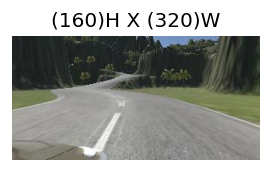

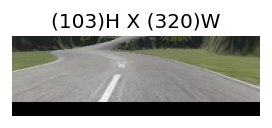

In [61]:
image_path = df_singleCamera.iloc[np.random.randint(0, df_singleCamera.shape[0])]['Camera']
folder, name, camera = extract_from_image_path(image_path)
img = fetch_image(name, TRAINING_IMAGES_FOLDER)
plot_images([img.copy()])
img = crop_image(img, 1/5, 25)
img, _ = shift_image(img,0, -18)
img.shape
plot_images([img.copy()])

C:\Users\kayeg\AppData\Local\Temp\ipykernel_47192\117794412.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(image == []):


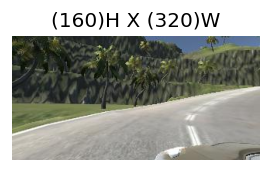

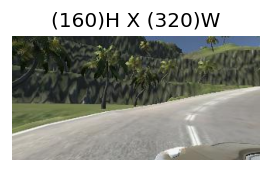

In [62]:
image_path = df_singleCamera.iloc[np.random.randint(0, df_singleCamera.shape[0])]['Camera']
folder, name, camera = extract_from_image_path(image_path)
img = fetch_image(name, TRAINING_IMAGES_FOLDER)

plot_images([img.copy()])

# img = crop_image(img, 1/5, 25)

# img = add_shadow(img)

random_brightness = generate_random_brightness(0.4)
img = change_image_brightness(img, random_brightness)

# img, _ = flip_image_V(img)
# img, _ = shift_image(img, 10, -18)

plot_images([img.copy()])

C:\Users\kayeg\AppData\Local\Temp\ipykernel_47192\117794412.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if(image == []):


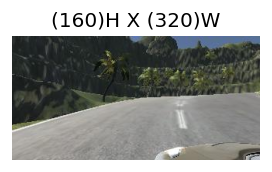

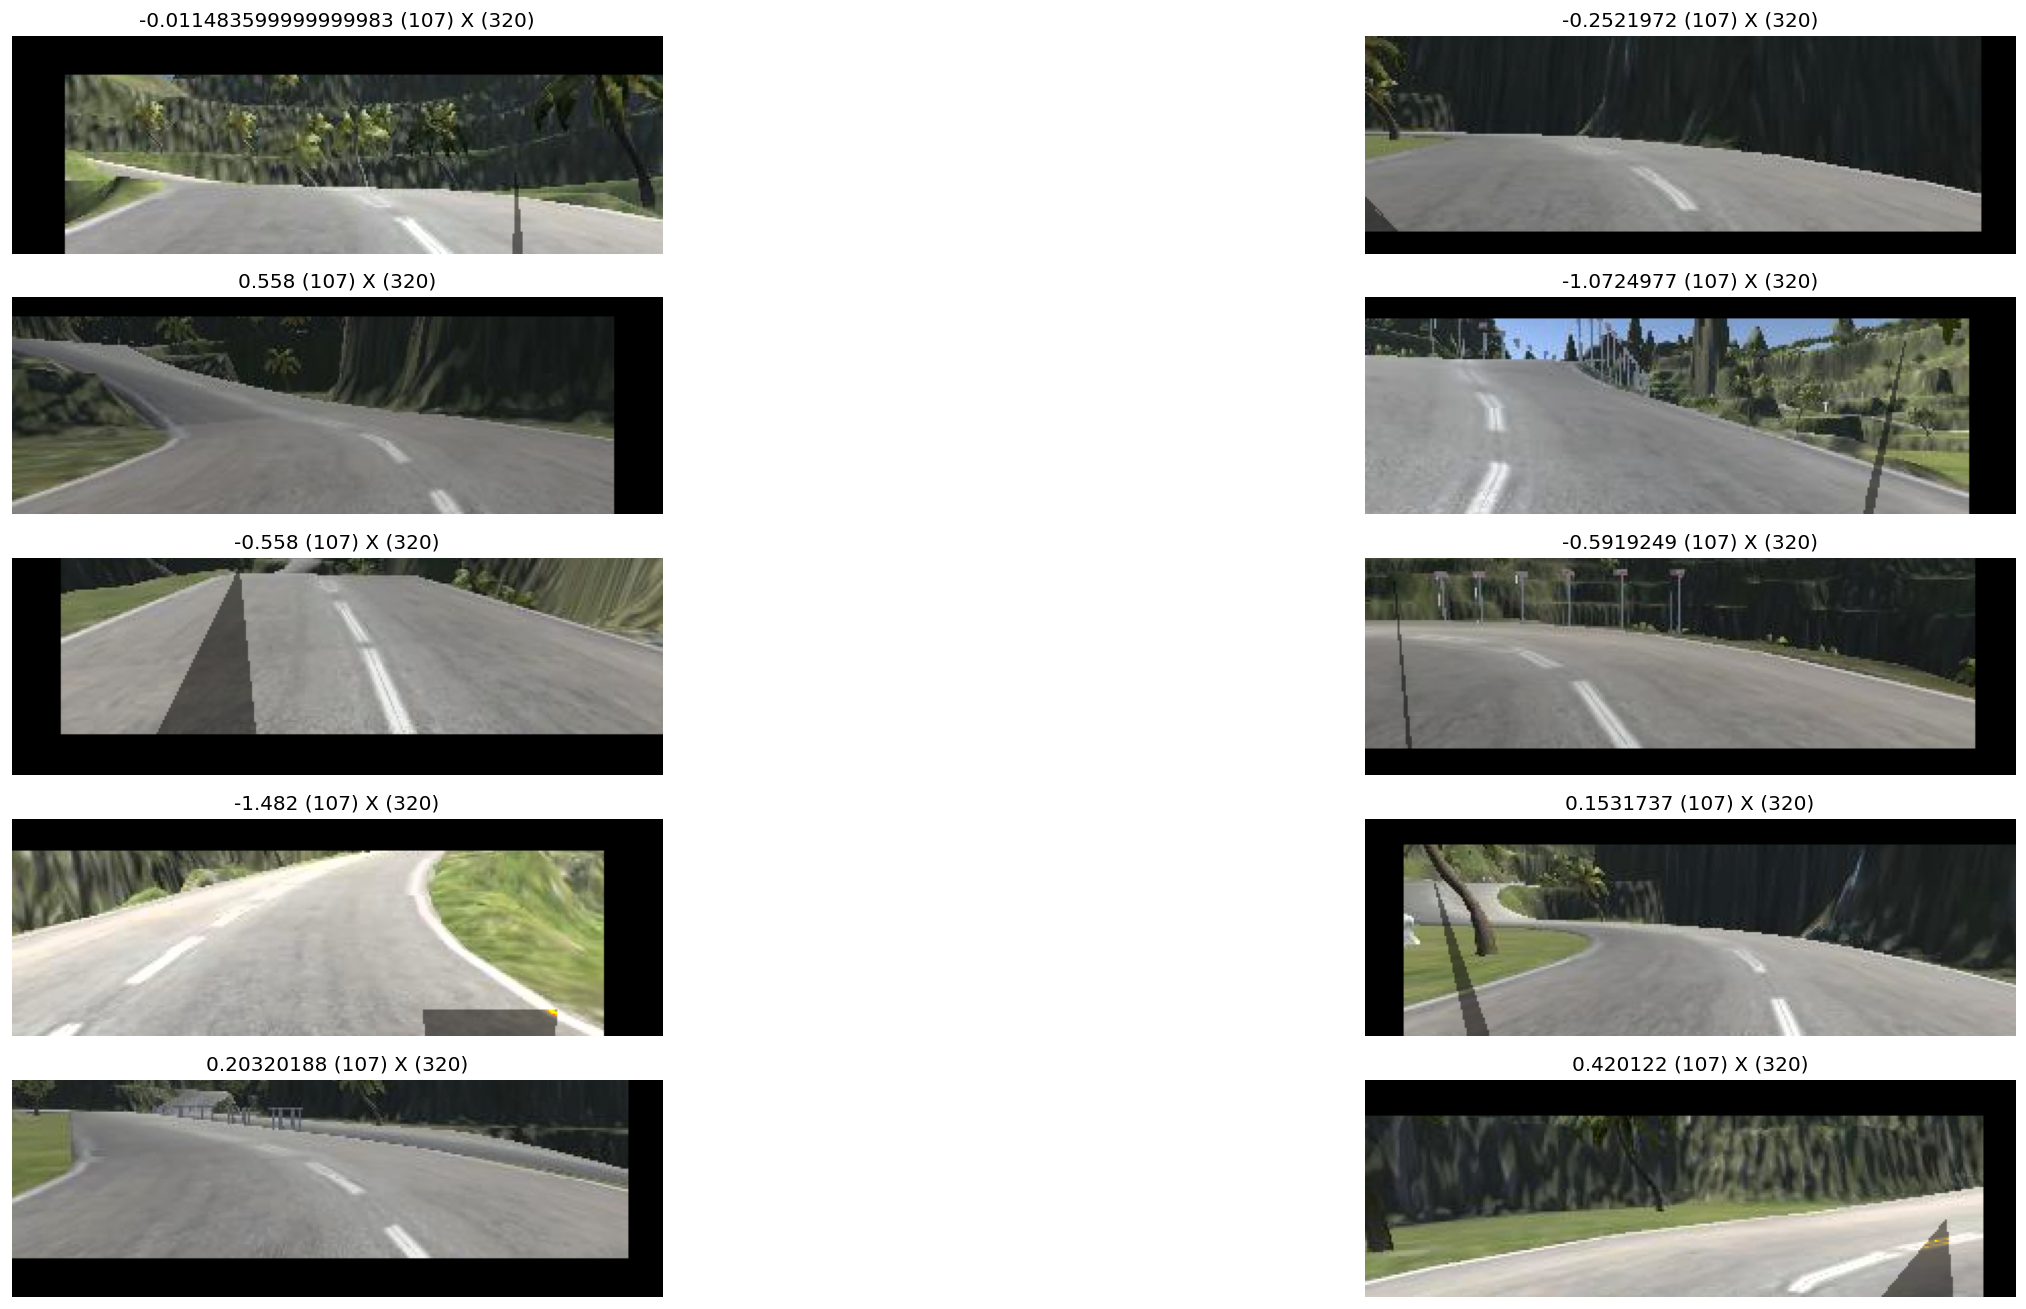

In [63]:
image_path = df_singleCamera.iloc[np.random.randint(0, df_singleCamera.shape[0])]['Camera']
folder, name, camera = extract_from_image_path(image_path)
img = fetch_image(name, folder)

plot_images([img.copy()])

# img = crop_image(img, 1/5, 25)

# img = add_shadow(img)
imgs = []
titles = []
for i in range(10):
    rand_row = np.random.randint(0, df_singleCamera.shape[0])
    
    image_path = df_singleCamera.iloc[rand_row]['Camera']
    title = df_singleCamera.iloc[rand_row]['Steering Angle']
    
    folder, name, camera = extract_from_image_path(image_path)
    img = fetch_image(name, folder)
    
    pre_img, f_a, s_a = apply_preprocessing(img, camera)
    title = (title+s_a)*f_a
    imgs.append(pre_img)
    titles.append(title)

plot_images(imgs, 2, 5, titles=titles)
# img, _ = flip_image_V(img)
# img, _ = shift_image(img, 10, -18)


## Generating Augmented Data


In [64]:
def apply_preprocessing(image, camera):
    image = crop_image(image, DEFAULT_TOP_CROP, DEFAULT_BOTTOM_CROP)
    image = resize_image(image, RESIZE_X, RESIZE_Y, as_factor=True)
    
    image = add_shadow(image)

    random_brightness = generate_random_brightness(BRIGHTNESS_MAX_RANGE, True, 0.1)
    image = change_image_brightness(image, random_brightness)

    x_shift = (DEFAULT_X_SHIFT*np.random.uniform(0,1) + MIN_X_SHIFT) * np.random.choice([-1, 1], 1)[0]
    y_shift = (DEFAULT_Y_SHIFT*np.random.uniform(0,1) + MIN_Y_SHIFT) * np.random.choice([-1, 1], 1)[0]
    # print(x_shift, y_shift)
    image, shift_adjusment = shift_image(image, x_shift, y_shift)

    if (LEFT_FLIP_BIAS) and (camera == 'left'):
        flip = weighted_random(1, 0.2)
    else:
        flip = np.random.uniform()

    if(flip > 1 - FLIP_PROBABILITY):
        image, flip_adjusment = flip_image_V(image)
    else:
        flip_adjusment = 1;

    
    return image, flip_adjusment, shift_adjusment

In [65]:
path_to_image = ['']*(df_singleCamera.shape[0]*AUGMENTATION_FACTOR)
adjusted_angle = ['']*(df_singleCamera.shape[0]*AUGMENTATION_FACTOR)

for row in range(df_singleCamera.shape[0]):
    image_path = df_singleCamera.iloc[row]['Camera']
    steering_angle = df_singleCamera.iloc[row]['Steering Angle']

    folder, name, camera = extract_from_image_path(image_path)

    original_image = fetch_image(name, folder)
    
    if (is_none(original_image)):
        print('Faild to fetch image at', row, folder, name)
        continue

    aug_fac = AUGMENTATION_FACTOR

    for i in range(aug_fac*row, aug_fac*row + aug_fac):
        preprocessed_image, flip_adjusment, shift_adjusment = apply_preprocessing(original_image.copy(), camera)
        
        pre_image_name = f'{i}_{camera}_image.jpg'
        pre_image_path = 'Augmented_Data_2.8.1/' + pre_image_name

        # df_augmented.loc[i] = [pre_image_path, steering_angle*flip_adjusment + shift_adjusment]
        path_to_image[i] = pre_image_path
        adjusted_angle[i] = round((steering_angle + shift_adjusment)*flip_adjusment, 3)

        image_saved = save_image(preprocessed_image, pre_image_name, AUG_IMAGE_FOLDER_PATH, overwrite=False)

        if is_none(image_saved):
            print('Overwrite Denined at', camera, i)

df_augmented = pd.DataFrame(data=zip(path_to_image, adjusted_angle), columns=['Image Path', 'Steering Angle'])
df_augmented

[save_image] Image already exists
Overwrite Denined at right 3
[save_image] Image already exists
Overwrite Denined at right 4
[save_image] Image already exists
Overwrite Denined at right 5
[save_image] Image already exists
Overwrite Denined at center 9
[save_image] Image already exists
Overwrite Denined at center 10
[save_image] Image already exists
Overwrite Denined at center 11
[save_image] Image already exists
Overwrite Denined at right 24
[save_image] Image already exists
Overwrite Denined at right 25
[save_image] Image already exists
Overwrite Denined at right 26
[save_image] Image already exists
Overwrite Denined at right 27
[save_image] Image already exists
Overwrite Denined at right 28
[save_image] Image already exists
Overwrite Denined at right 29
[save_image] Image already exists
Overwrite Denined at center 54
[save_image] Image already exists
Overwrite Denined at center 55
[save_image] Image already exists
Overwrite Denined at center 56
[save_image] Image already exists
Over

,Image Path,Steering Angle
0,Augmented_Data_2.8.1/0_center_image.jpg,0.160
1,Augmented_Data_2.8.1/1_center_image.jpg,0.128
2,Augmented_Data_2.8.1/2_center_image.jpg,-0.232
3,Augmented_Data_2.8.1/3_right_image.jpg,0.450
4,Augmented_Data_2.8.1/4_right_image.jpg,0.434
...,...,...
17146,Augmented_Data_2.8.1/17146_right_image.jpg,0.442
17147,Augmented_Data_2.8.1/17147_right_image.jpg,-0.058
17148,Augmented_Data_2.8.1/17148_left_image.jpg,-0.026
17149,Augmented_Data_2.8.1/17149_left_image.jpg,-0.474


<AxesSubplot:xlabel='Steering Angle', ylabel='Count'>

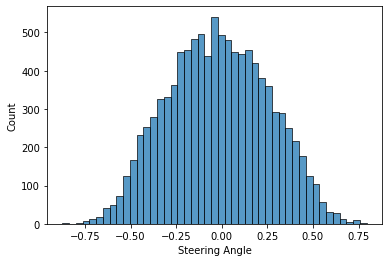

In [7]:
df = pd.read_csv("Data\Training Data (1.3)\\augmented_df.csv")
sea.histplot(df['Steering Angle'])

In [66]:
df_augmented.isna().sum()

Image Path        0
Steering Angle    0
dtype: int64

In [67]:
df_augmented.to_csv(AUGMENTED_DATASET)